In [33]:
## IMPORTS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import unicodedata
from wordcloud import WordCloud

import sqlPull as sp

np.random.seed(42)

# Exercises

    1. Spam Data
        a. Load the spam data set.
        b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
        c. Is there any overlap in the bigrams for the spam data and the ham data?
        d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

    2. Explore the blog articles using the techniques discussed in the exploration lesson.

    3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.


In [2]:
df = sp.get_mysql_data('SELECT * FROM spam', 'spam_db')
df = df.set_index('id')

In [3]:
df.head()

label                                               text
id                                                         
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...

In [4]:
df.shape

(5572, 2)

In [39]:
# copying function from Codeup syllabus
# this function does the basic_clean and lemmatizing.
# instead of using a tokenize function, it splits up the string into words via re.sub below

ADDITIONAL_STOPWORDS = ['r', 'u', '2', '4', 'ltgt']

def clean(text):
    'A simple function to cleanup text data; takes in a string; returns a list of strings (words)'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    # this line is in place of tokenize I think
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [40]:
# following syllabus first; looking at how many messages are spam vs ham
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [41]:
# syllabus defined this function to do a value_counts with percentage as well
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

In [42]:
show_counts_and_ratios(df, "label")

n   percent
ham   4825  0.865937
spam   747  0.134063

In [43]:
## Break up data into 3 pieces: ham words, spam words, all words (lists of words)

# Note:  I could use my basic_clean function, but I'd have to split the single string it returns

# join all ham/spam/all texts together into one string, send it into clean, get back a list of words
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [44]:
# get a series of value counts for each of ham/spam/all_words
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [45]:
spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [46]:
# combine ham/spam/all_freq into a dataframe called word_counts
word_counts = pd.concat([all_freq, ham_freq, spam_freq], axis = 1, sort=True)
# fill na with 0
word_counts = word_counts.fillna(0)
# make values integers instead of floats
word_counts = word_counts.apply(lambda s: s.astype(int))
# rename the columns
word_counts.columns = ['all', 'ham', 'spam']
word_counts.head()

all  ham  spam
0               3    0     3
008704050406    2    0     2
0089my          1    0     1
0121            1    0     1
01223585236     1    0     1

In [47]:
# what are the most common words?
word_counts.sort_values('all', ascending=False).head(10)

all  ham  spam
call  600  241   359
im    462  449    13
get   397  314    83
ur    384  240   144
go    304  273    31
dont  279  257    22
ok    277  272     5
free  275   59   216
know  267  241    26
come  247  242     5

In [48]:
# what are most common ham words?
word_counts.sort_values('ham', ascending=False).head()

all  ham  spam
im    462  449    13
get   397  314    83
go    304  273    31
ok    277  272     5
dont  279  257    22

In [49]:
# what are the most common ham words that are uniquely ham?
word_counts[word_counts.spam == 0].sort_values('ham', ascending=False).head(6)

all  ham  spam
lor    160  160     0
later  134  134     0
da     132  132     0
say    118  118     0
i_     117  117     0
thats   94   94     0

In [50]:
# what are the most common spam words that are uniquely spam?
word_counts[word_counts.ham == 0].sort_values('spam', ascending=False).head(6)

all  ham  spam
claim       115    0   115
prize        94    0    94
tone         73    0    73
guaranteed   50    0    50
18           43    0    43
awarded      38    0    38

In [53]:
# setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

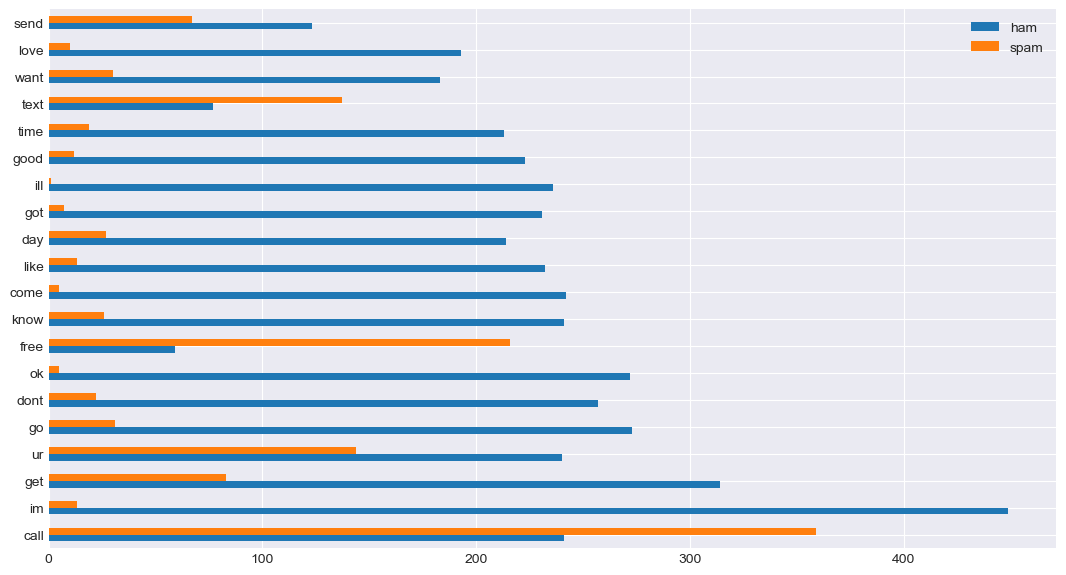

In [56]:
# visualization of top 20 words and ham vs spam
word_counts.sort_values('all', ascending=False)[['ham', 'spam']].head(20).plot.barh()
plt.show()

In [57]:
# prep for a different plot: get percentage of ham/spam vs all for top 20 words
word_counts.sort_values('all', ascending=False).head(20)\
.apply(lambda row: row/row['all'], axis=1)

all       ham      spam
call  1.0  0.401667  0.598333
im    1.0  0.971861  0.028139
get   1.0  0.790932  0.209068
ur    1.0  0.625000  0.375000
go    1.0  0.898026  0.101974
dont  1.0  0.921147  0.078853
ok    1.0  0.981949  0.018051
free  1.0  0.214545  0.785455
know  1.0  0.902622  0.097378
come  1.0  0.979757  0.020243
like  1.0  0.946939  0.053061
day   1.0  0.887967  0.112033
got   1.0  0.970588  0.029412
ill   1.0  0.995781  0.004219
good  1.0  0.948936  0.051064
time  1.0  0.918103  0.081897
text  1.0  0.359813  0.640187
want  1.0  0.859155  0.140845
love  1.0  0.950739  0.049261
send  1.0  0.647368  0.352632

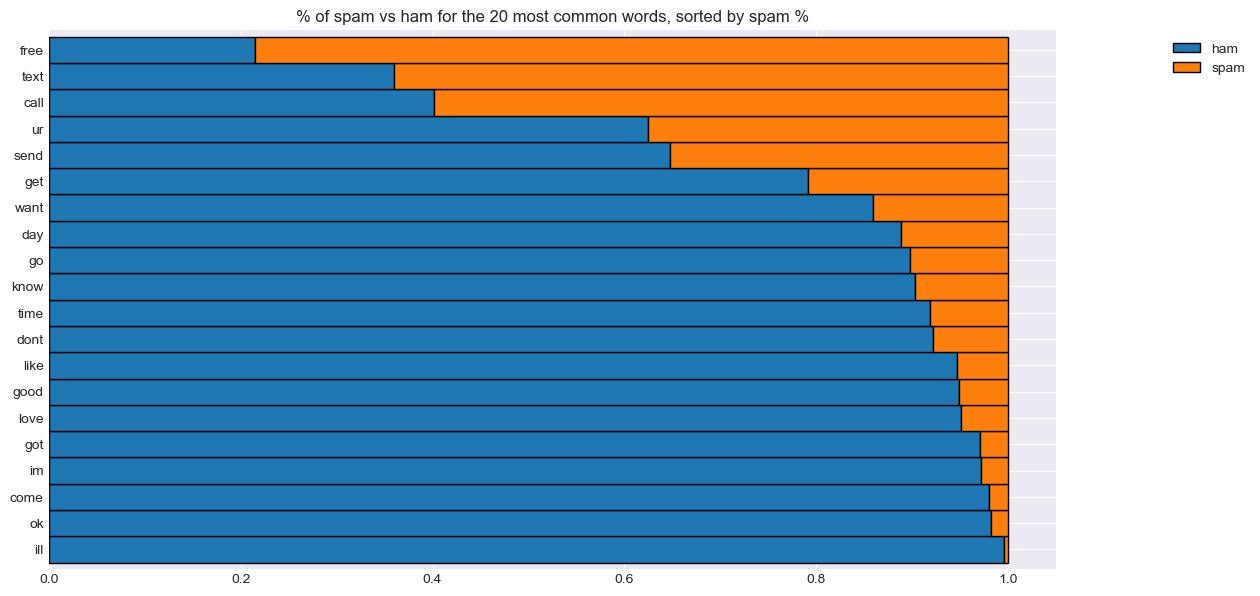

In [72]:
(word_counts.sort_values('all', ascending=False).head(20)
.apply(lambda row: row/row['all'], axis=1)
.drop(columns='all')
.sort_values('spam')
.plot.barh(stacked=True, width=1, ec='black')
)

plt.title('% of spam vs ham for the 20 most common words, sorted by spam %')
# put legend outside of plot
plt.legend(bbox_to_anchor=(1.2, 1.0), loc='upper right')
plt.show()

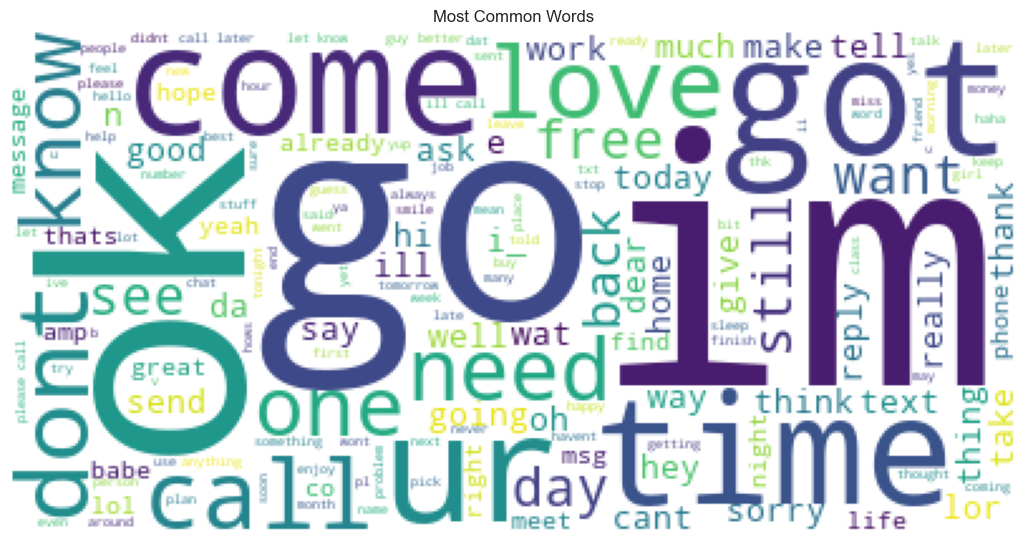

In [76]:
# generate some word clouds - start with single words
all_cloud = WordCloud(background_color='white').generate(' '.join(all_words))
plt.imshow(all_cloud)
plt.axis('off')
plt.title('Most Common Words')
plt.show()

In [51]:
# make bigrams
ham_bigrams = pd.Series(nltk.bigrams(ham_words)).value_counts()
spam_bigrams = pd.Series(nltk.bigrams(spam_words)).value_counts()
all_bigrams = pd.Series(nltk.bigrams(all_words)).value_counts()

In [71]:
all_bigrams.head(20)

(please, call)         53
(call, later)          52
(ill, call)            48
(let, know)            42
(sorry, ill)           39
(dont, know)           38
(new, year)            32
(good, morning)        31
(customer, service)    29
(take, care)           26
(po, box)              25
(im, going)            24
(guaranteed, call)     23
(a1000, cash)          23
(prize, guaranteed)    22
(ok, lor)              22
(pls, send)            22
(every, week)          21
(im, gonna)            20
(free, call)           20
dtype: int64

In [62]:
# combine ham/spam/all_bigrams into a dataframe called bigram_counts
bigram_counts = pd.concat([all_bigrams, ham_bigrams, spam_bigrams], axis = 1, sort=True)
# fill na with 0
bigram_counts = bigram_counts.fillna(0)
# make values integers instead of floats
bigram_counts = bigram_counts.apply(lambda s: s.astype(int))
# rename the columns
bigram_counts.columns = ['all', 'ham', 'spam']
bigram_counts.sort_values('all', ascending=False).head()

all  ham  spam
please call    53    9    44
call   later   52   52     0
ill    call    48   48     0
let    know    42   42     0
sorry  ill     39   39     0

In [77]:
bigram_counts.sort_values('ham', ascending=False).head()

all  ham  spam
call  later   52   52     0
ill   call    48   48     0
let   know    42   42     0
sorry ill     39   39     0
dont  know    38   32     6

In [78]:
bigram_counts.sort_values('spam', ascending=False).head()

all  ham  spam
please     call      53    9    44
customer   service   29    2    27
po         box       25    1    24
a1000      cash      23    0    23
guaranteed call      23    0    23

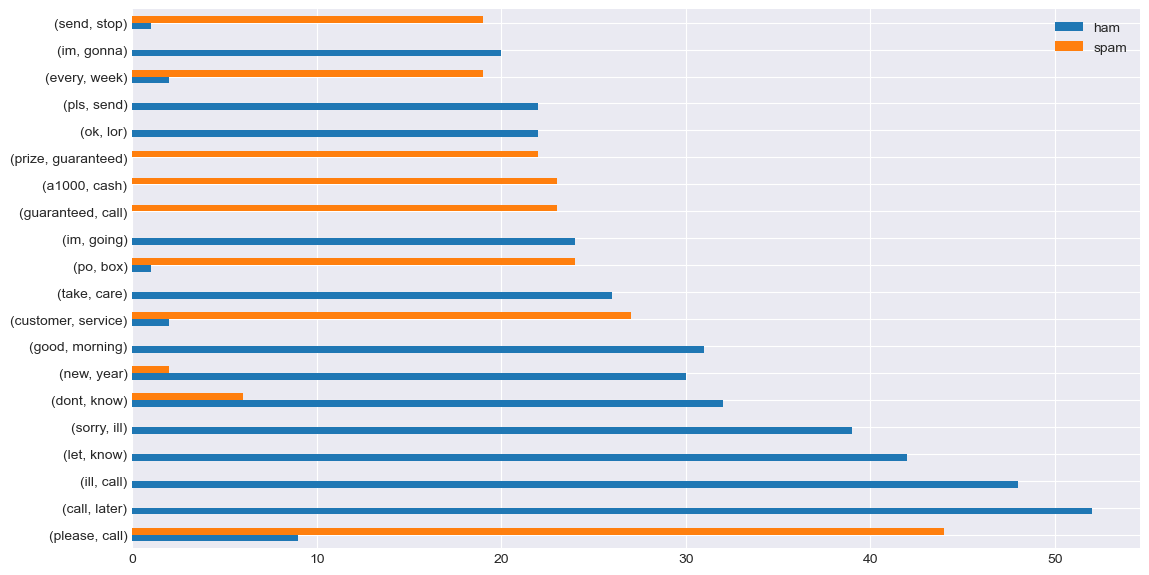

In [79]:
# visualization of top 20 bigrams and ham vs spam
bigram_counts.sort_values('all', ascending=False)[['ham', 'spam']].head(20).plot.barh()
plt.show()

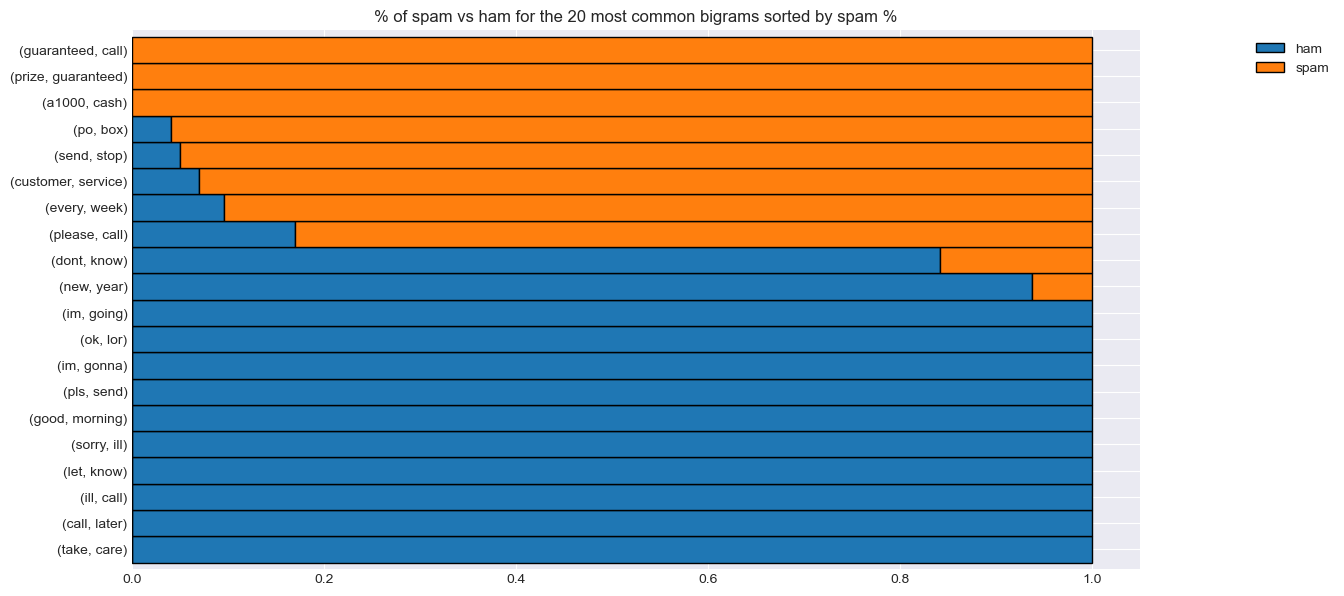

In [73]:
(bigram_counts.sort_values('all', ascending=False).head(20)
.apply(lambda row: row/row['all'], axis=1)
.drop(columns='all')
.sort_values('spam')
.plot.barh(stacked=True, width=1, ec='black')
)

plt.title('% of spam vs ham for the 20 most common bigrams sorted by spam %')
# put legend outside of plot
plt.legend(bbox_to_anchor=(1.2, 1.0), loc='upper right')
plt.show()

In [154]:
# to_dict changes series to a dictionary
# items changes the dictionary into a list of (key, value) tuples
all_bigrams.to_dict().items()

dict_items([(('please', 'call'), 53), (('call', 'later'), 52), (('ill', 'call'), 48), (('let', 'know'), 42), (('sorry', 'ill'), 39), (('dont', 'know'), 38), (('new', 'year'), 32), (('good', 'morning'), 31), (('customer', 'service'), 29), (('take', 'care'), 26), (('po', 'box'), 25), (('im', 'going'), 24), (('guaranteed', 'call'), 23), (('a1000', 'cash'), 23), (('prize', 'guaranteed'), 22), (('ok', 'lor'), 22), (('pls', 'send'), 22), (('every', 'week'), 21), (('im', 'gonna'), 20), (('free', 'call'), 20), (('send', 'stop'), 20), (('selected', 'receive'), 19), (('chance', 'win'), 19), (('await', 'collection'), 19), (('good', 'night'), 19), (('happy', 'new'), 19), (('land', 'line'), 18), (('last', 'night'), 18), (('hi', 'hi'), 18), (('urgent', 'mobile'), 18), (('wat', 'time'), 18), (('claim', 'call'), 17), (('great', 'day'), 17), (('valid', '12hrs'), 17), (('sae', 'tc'), 16), (('prize', 'claim'), 16), (('account', 'statement'), 16), (('call', '08000930705'), 16), (('send', 'message'), 15), 

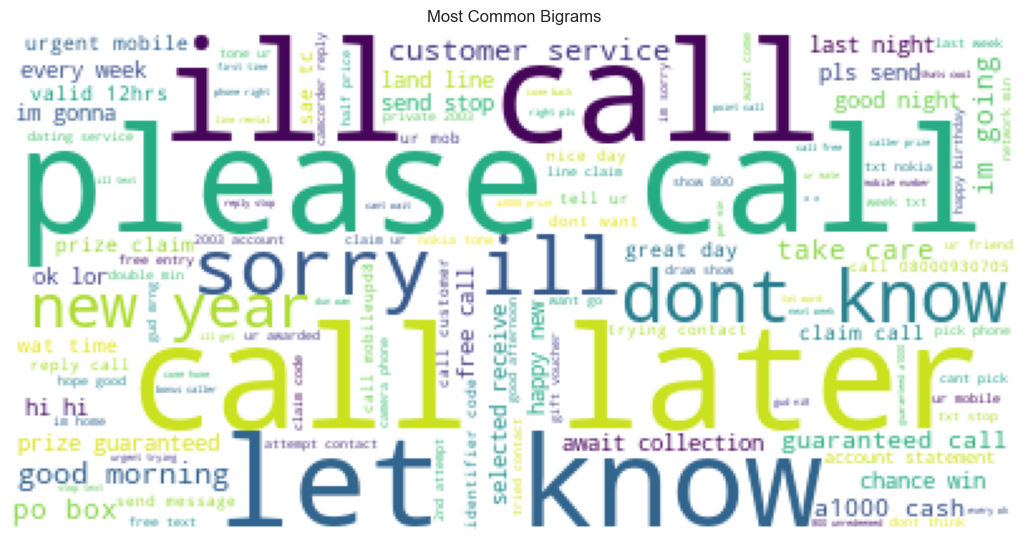

In [156]:
# generate bigram clouds
# use generate_from_frequencies method. supplied values must be in form of a 
# dictionary where the keys are the words (phrases), and the values are numbers that
# correspond to the size

# convert the series to a dictioinary and convert tuples that make up the index into a
# single string that holds each phrase

data = {k[0] + ' ' + k[1]: v for k,v in all_bigrams.to_dict().items()}
all_bigram_cloud = WordCloud(background_color='white').generate_from_frequencies(data)
plt.imshow(all_bigram_cloud)
plt.axis('off')
plt.title('Most Common Bigrams')
plt.show()

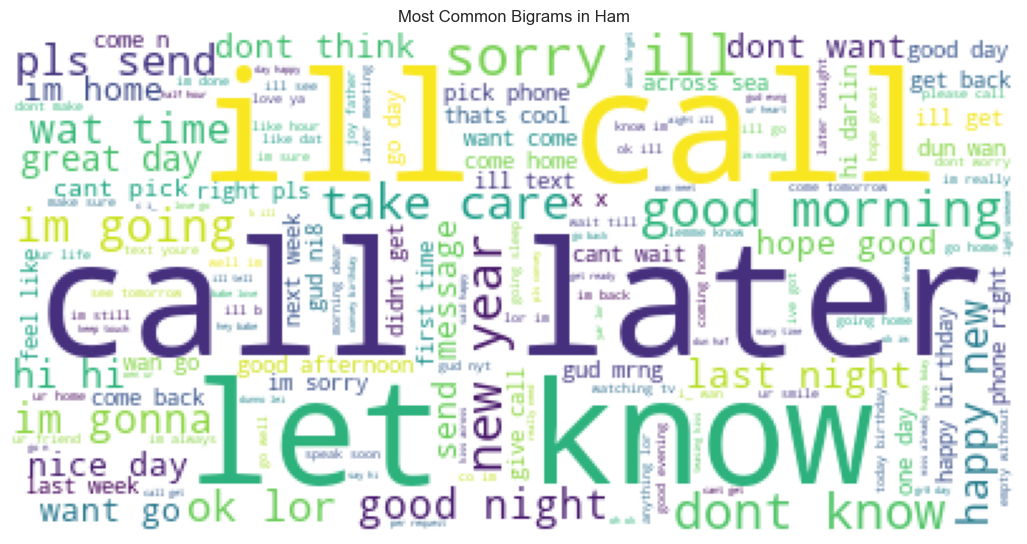

In [88]:
# generate word cloud for most common bigrams in ham
data = {k[0] + ' ' + k[1]: v for k,v in ham_bigrams.to_dict().items()}
ham_bigram_cloud = WordCloud(background_color='white').generate_from_frequencies(data)
plt.imshow(ham_bigram_cloud)
plt.axis('off')
plt.title('Most Common Bigrams in Ham')
plt.show()

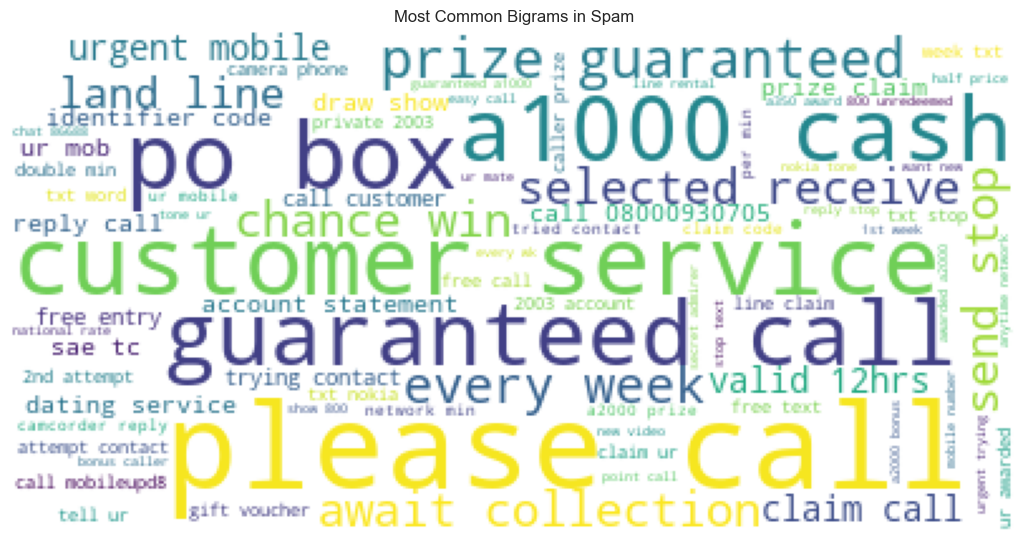

In [89]:
# generate word cloud for most common bigrams in spam
data = {k[0] + ' ' + k[1]: v for k,v in spam_bigrams.to_dict().items()}
spam_bigram_cloud = WordCloud(background_color='white').generate_from_frequencies(data)
plt.imshow(spam_bigram_cloud)
plt.axis('off')
plt.title('Most Common Bigrams in Spam')
plt.show()

## Spam Data Exercise questions:

    Load the spam data set.
    Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
    
    * Hard to put in words. spam bigrams have things that are trying to get your attention and elicit a response (guaranteed ..., please call, await collection, a1000 cash...)  ham bigrams seem to be more responses or greetings (i'll call, call later, let know, good morning, ...)
    
    Is there any overlap in the bigrams for the spam data and the ham data?
    
    * not very much. in the top 20 bigrams, it was either 80%+ ham or 80%+ spam. Nothing was in-between (at least in the top 20)

### Investigating overlap in bigrams between ham and spam

* bottom line, the most common bigrams that were between 40%/60% ham/spam (or vice versa) only occured 7 times (call, back) and (day, send)

In [105]:
# make a dataframe of the percent ham/spam
bigram_percents = (bigram_counts.sort_values('all', ascending=False)
.apply(lambda row: row/row['all'], axis=1)
)

In [106]:
# merge percents with counts 
bigram_percents_all = bigram_counts.merge(bigram_percents, left_on=bigram_counts.index, right_on=bigram_percents.index)

In [107]:
bigram_percents_all.head()

key_0  all_x  ham_x  spam_x  all_y  ham_y  spam_y
0           (0, game)      2      0       2    1.0    0.0     1.0
1            (0, key)      1      0       1    1.0    0.0     1.0
2  (008704050406, sp)      2      0       2    1.0    0.0     1.0
3      (0089my, last)      1      0       1    1.0    0.0     1.0
4     (0121, 2025050)      1      0       1    1.0    0.0     1.0

In [108]:
# look where percentages are between .4 and .6 for ham bigrams (should be same for spam)
bigram_percents_all[(bigram_percents_all.ham_y >= .4) & (bigram_percents_all.ham_y <= .6)].sort_values('all_x')

key_0  all_x  ham_x  spam_x  all_y     ham_y    spam_y
1033      (26th, july)      2      1       1    1.0  0.500000  0.500000
28355    (save, money)      2      1       1    1.0  0.500000  0.500000
28160  (safe, getting)      2      1       0    1.0  0.500000  0.000000
27529    (reply, free)      2      1       1    1.0  0.500000  0.500000
25428    (phone, send)      2      1       1    1.0  0.500000  0.500000
...                ...    ...    ...     ...    ...       ...       ...
6018      (call, call)      5      3       2    1.0  0.600000  0.400000
13389        (get, ur)      5      3       2    1.0  0.600000  0.400000
36003      (want, get)      5      3       2    1.0  0.600000  0.400000
8973       (day, send)      7      4       3    1.0  0.571429  0.428571
6009      (call, back)      7      3       4    1.0  0.428571  0.571429

[104 rows x 7 columns]

## Exercises 1.d: 
* Create and explore with trigrams for both ham and spam

In [110]:
# make trigrams
# make bigrams
ham_trigrams = pd.Series(nltk.ngrams(ham_words, 3)).value_counts()
spam_trigrams = pd.Series(nltk.ngrams(spam_words, 3)).value_counts()
all_trigrams = pd.Series(nltk.ngrams(all_words, 3)).value_counts()

In [111]:
all_trigrams.head()

(ill, call, later)           42
(sorry, ill, call)           38
(prize, guaranteed, call)    21
(happy, new, year)           19
(call, customer, service)    15
dtype: int64

In [112]:
ham_trigrams.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(pick, phone, right)    12
dtype: int64

In [113]:
# combine ham/spam/all_trigrams into a dataframe called trigram_counts
trigram_counts = pd.concat([all_trigrams, ham_trigrams, spam_trigrams], axis = 1, sort=True)
# fill na with 0
trigram_counts = trigram_counts.fillna(0)
# make values integers instead of floats
trigram_counts = trigram_counts.apply(lambda s: s.astype(int))
# rename the columns
trigram_counts.columns = ['all', 'ham', 'spam']
trigram_counts.sort_values('all', ascending=False).head()

all  ham  spam
ill   call       later     42   42     0
sorry ill        call      38   38     0
prize guaranteed call      21    0    21
happy new        year      19   19     0
call  customer   service   15    0    15

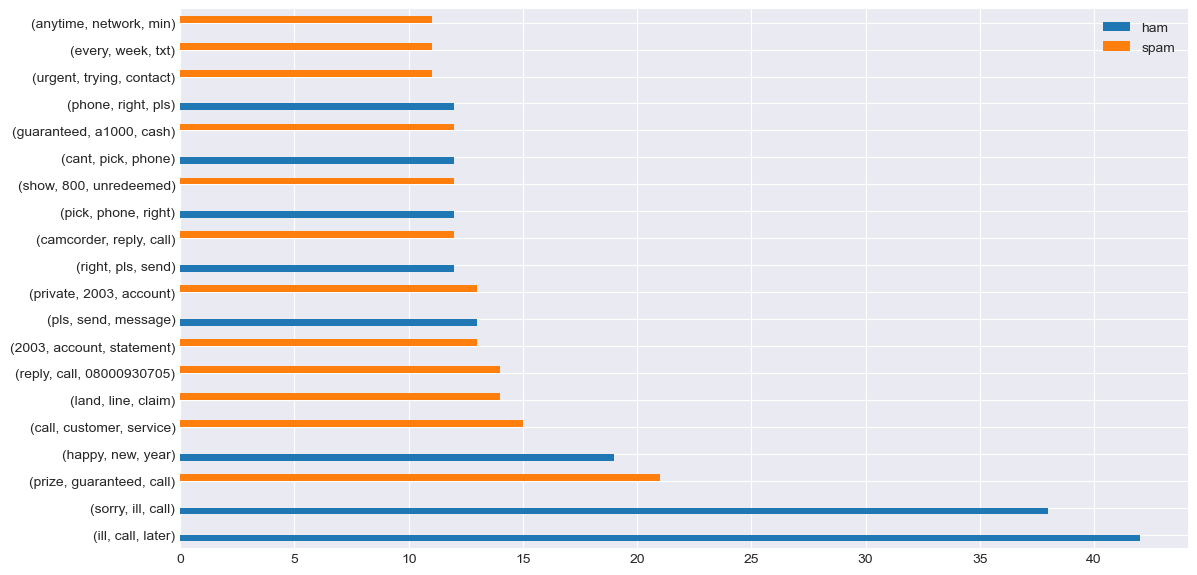

In [114]:
# visualization of top 20 trigrams and ham vs spam
trigram_counts.sort_values('all', ascending=False)[['ham', 'spam']].head(20).plot.barh()
plt.show()

In [117]:
# ZERO Overlap in the trigrams in the top 20, what about the rest
# show df with at least 1 count for ham and for spam to see which trigrams were found in both ham/spam
trigram_counts[(trigram_counts.ham != 0) & (trigram_counts.spam !=0)]

all  ham  spam
called left   message    2    1     1
new    year   eve        2    1     1
number im     glad       2    1     1
please call   back       5    1     4
sorry  missed call       3    2     1

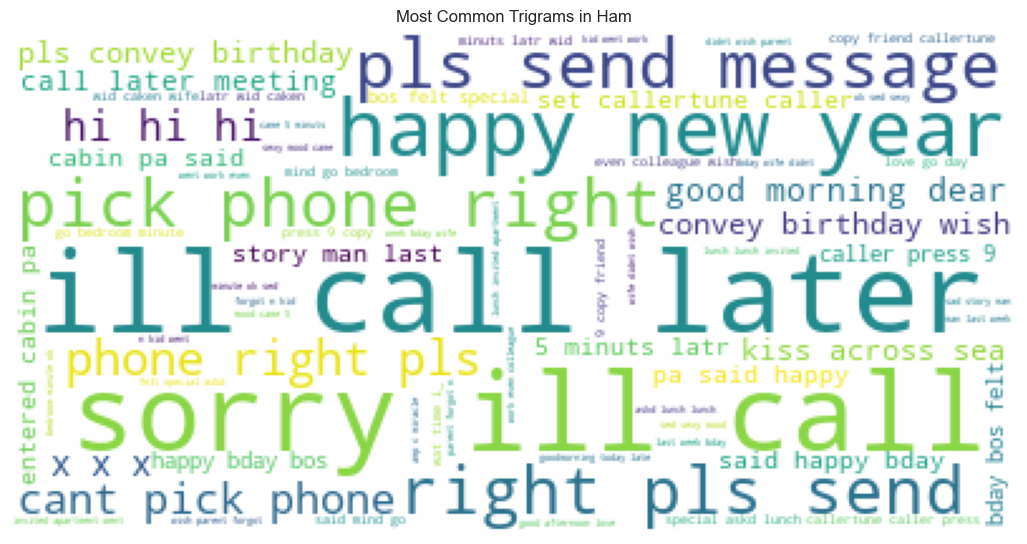

In [118]:
# quick word cloud for most common trigrams in ham
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k,v in ham_trigrams.to_dict().items()}
ham_trigram_cloud = WordCloud(background_color='white').generate_from_frequencies(data)
plt.imshow(ham_trigram_cloud)
plt.axis('off')
plt.title('Most Common Trigrams in Ham')
plt.show()

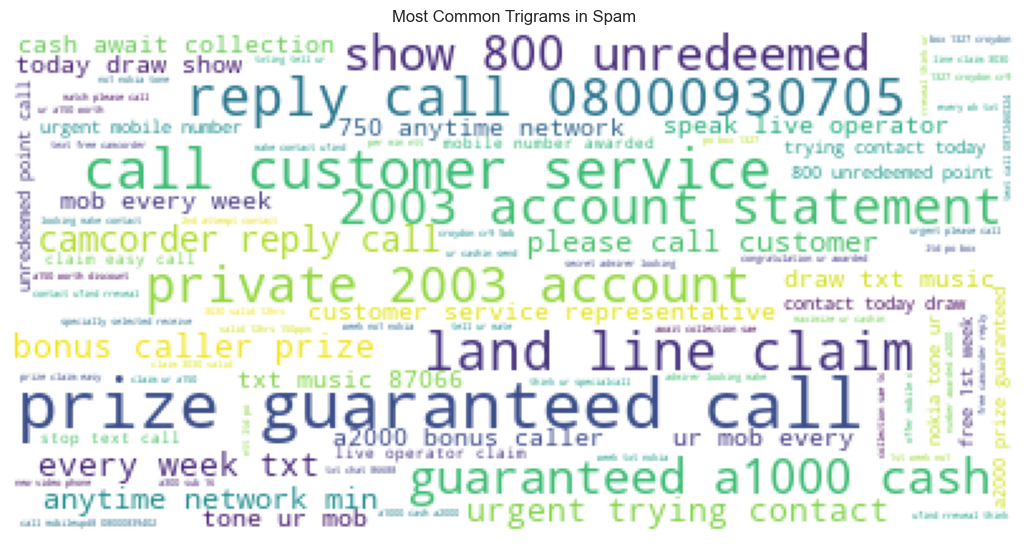

In [119]:
# word cloud for most common trigrams in spam
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k,v in spam_trigrams.to_dict().items()}
spam_trigram_cloud = WordCloud(background_color='white').generate_from_frequencies(data)
plt.imshow(spam_trigram_cloud)
plt.axis('off')
plt.title('Most Common Trigrams in Spam')
plt.show()

# Exercise #2.
* Explore the blog articles using the techniques discussed in the exploration lesson

In [120]:
import acquire as a

In [121]:
df = a.get_all_codeup_blogs()

cached file found and read


In [123]:
df = pd.DataFrame(df)
df.head()

title  \
0  Spotlight on APIDA Voices: Celebrating Heritag...   
1  Women in tech: Panelist Spotlight – Magdalena ...   
2  Women in tech: Panelist Spotlight - Rachel Rob...   
3  Women in Tech: Panelist Spotlight - Sarah Mell...   
4  Women in Tech: Panelist Spotlight - Madeleine ...   

                                             content  
0  Spotlight on APIDA Voices: Celebrating Heritag...  
1  Women in tech: Panelist Spotlight – Magdalena ...  
2  Women in tech: Panelist Spotlight – Rachel Rob...  
3  Women in Tech: Panelist Spotlight – Sarah Mell...  
4  Women in Tech: Panelist Spotlight – Madeleine ...

In [124]:
df.shape

(270, 2)

In [128]:
df.iloc[0].title

'Spotlight on APIDA Voices: Celebrating Heritage and Inspiring Change ft. Arbeena Thapa'

In [127]:
# I could do three pieces again, but the title appears in the content (probably need to fix that),
# so I'll just go with content
df.iloc[0].content

'Spotlight on APIDA Voices: Celebrating Heritage and Inspiring Change ft. Arbeena Thapa May 24, 2023 | Featured   May is traditionally known as Asian American and Pacific Islander (AAPI) Heritage Month. This month we celebrate the history and contributions made possible by our AAPI friends, family, and community. We also examine our level of support and seek opportunities to better understand the AAPI community.  In an effort to address real concerns and experiences, we sat down with Arbeena Thapa, one of Codeup’s Financial Aid and Enrollment Managers. Arbeena identifies as Nepali American and Desi. Arbeena’s parents immigrated to Texas in 1988 for better employment and educational opportunities. Arbeena’s older sister was five when they made the move to the US. Arbeena was born later, becoming the first in her family to be a US citizen. At Codeup we take our efforts at inclusivity very seriously. After speaking with Arbeena, we were taught that the term AAPI excludes Desi-American ind

In [129]:
# join all content's together into one string, send it into clean, get back a list of words
blog_words = clean(' '.join(df.content))

In [131]:
blog_words[:10]

['spotlight',
 'apida',
 'voice',
 'celebrating',
 'heritage',
 'inspiring',
 'change',
 'ft',
 'arbeena',
 'thapa']

In [132]:
len(blog_words)

77197

In [134]:
blog_word_counts = pd.Series(blog_words).value_counts()
blog_word_counts.head()

codeup     1248
data        769
student     594
career      568
program     526
dtype: int64

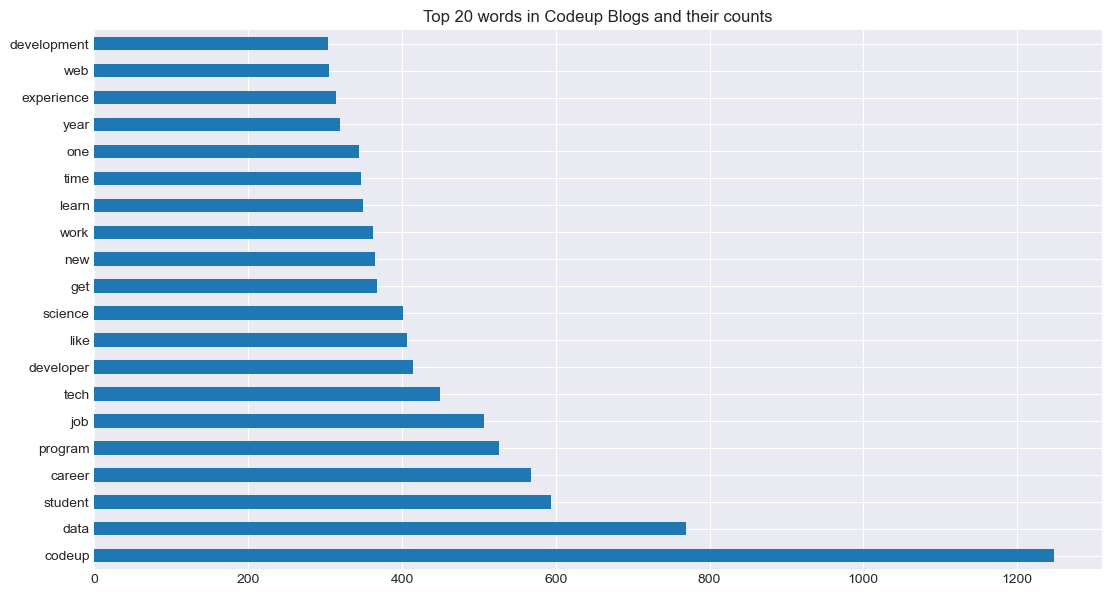

In [136]:
blog_word_counts.head(20).plot.barh()
plt.title('Top 20 words in Codeup Blogs and their counts')
plt.show()

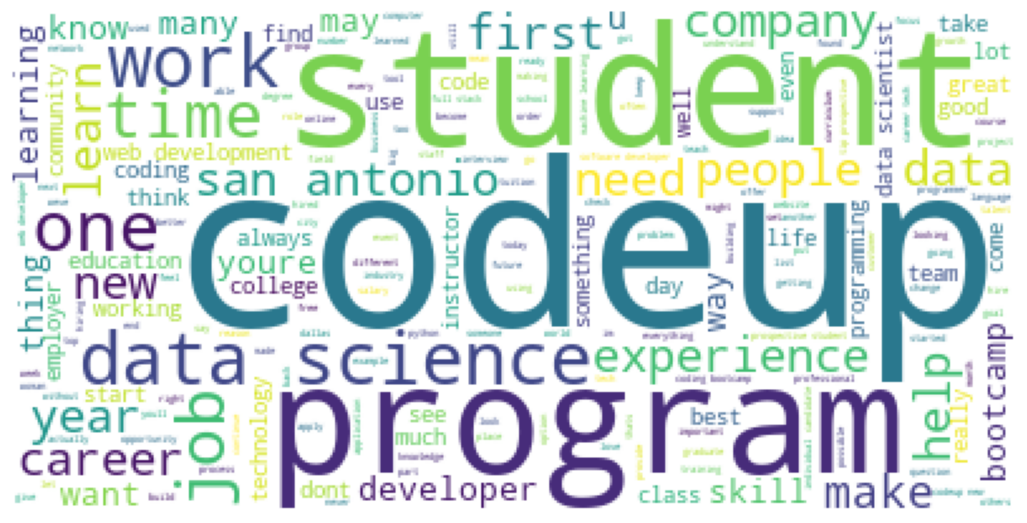

In [138]:
blog_cloud = WordCloud(background_color='white').generate(' '.join(blog_words))
plt.imshow(blog_cloud)
plt.axis('off')
plt.show()

# Exercise 3.
* Explore the news articles using the techniques discussed in the exploration lesson. Use the 'category' variable when exploring

In [139]:
df = pd.DataFrame(a.get_news_articles())
df.head()

cached file found and read


category                                              title  \
0  business           Sensex, Nifty end at fresh closing highs   
1  business  TIME releases list of the world's 100 most inf...   
2  business  Which are the world's top 10 airlines accordin...   
3  business  Loves India, is a fan of PM: Paytm Founder on ...   
4  business  UK's net debt passes 100% of GDP for the first...   

                                             content  
0  Benchmark indices Sensex and Nifty ended at re...  
1  TIME magazine has released its annual list of ...  
2  Singapore Airlines is the world's best airline...  
3  Paytm Founder Vijay Shekhar Sharma shared a vi...  
4  The United Kingdom's public sector net debt in...

In [140]:
## Break up data into 5 pieces: business, sports, technology, entertainment, all (lists of words)

# Note:  I could use my basic_clean function, but I'd have to split the single string it returns

# join all types of contents together into one string, send it into clean, get back a list of words
bus_words = clean(' '.join(df[df.category == 'business'].content))
sports_words = clean(' '.join(df[df.category == 'sports'].content))
tech_words = clean(' '.join(df[df.category == 'technology'].content))
entmnt_words = clean(' '.join(df[df.category == 'entertainment'].content))
all_words = clean(' '.join(df.content))

In [143]:
# get a series of value counts for each of categories and for all_words
bus_freq = pd.Series(bus_words).value_counts()
sports_freq = pd.Series(sports_words).value_counts()
tech_freq = pd.Series(tech_words).value_counts()
entmnt_freq = pd.Series(entmnt_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [142]:
bus_freq.head()

said         16
india        10
wednesday    10
share         8
yoga          7
dtype: int64

In [146]:
# combine category_freqs and all_freq into a dataframe called word_counts
news_word_counts = pd.concat([all_freq, bus_freq, sports_freq, tech_freq, entmnt_freq], axis = 1, sort=True)
# fill na with 0
news_word_counts = news_word_counts.fillna(0)
# make values integers instead of floats
news_word_counts = news_word_counts.apply(lambda s: s.astype(int))
# rename the columns
news_word_counts.columns = ['all', 'business', 'sports', 'technology', 'entertainment']
news_word_counts.head()

all  business  sports  technology  entertainment
01     1         0       1           0              0
041    1         1       0           0              0
1      5         2       3           0              0
10     1         0       1           0              0
100    3         2       0           1              0

In [148]:
news_word_counts.sort_values('all', ascending=False)

all  business  sports  technology  entertainment
said        75        16      13          22             24
added       33         6       9           4             14
india       25        10       2          13              0
test        25         0      24           0              1
australia   22         2      20           0              0
...        ...       ...     ...         ...            ...
give         1         0       1           0              0
girl         1         1       0           0              0
giriraj      1         0       0           0              1
generic      1         1       0           0              0
kane         1         0       1           0              0

[1924 rows x 5 columns]

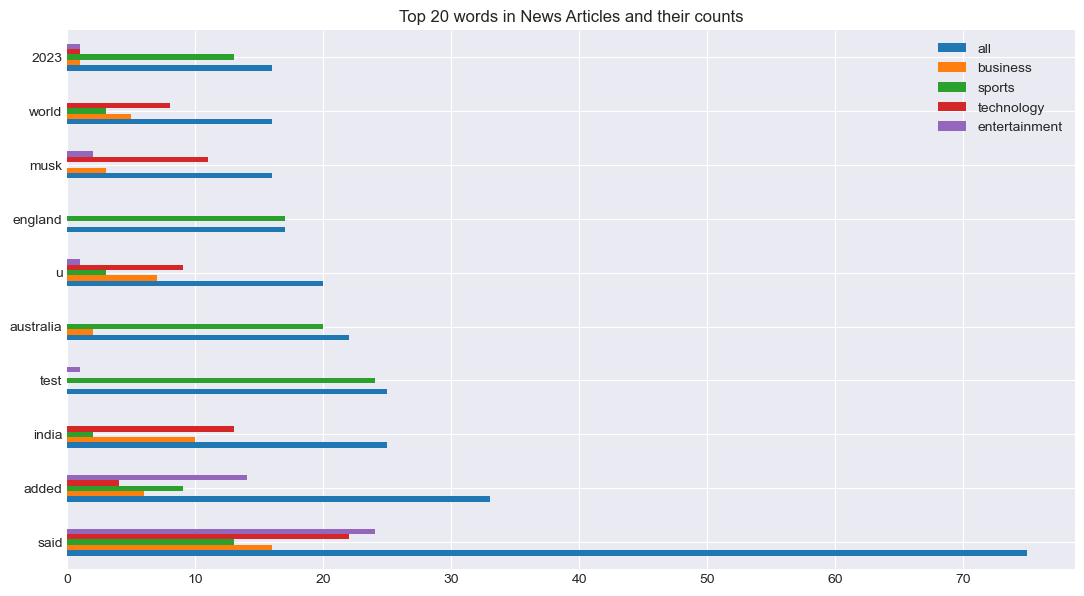

In [151]:
news_word_counts.sort_values('all', ascending=False).head(10).plot.barh()
plt.title('Top 20 words in News Articles and their counts')
plt.show()

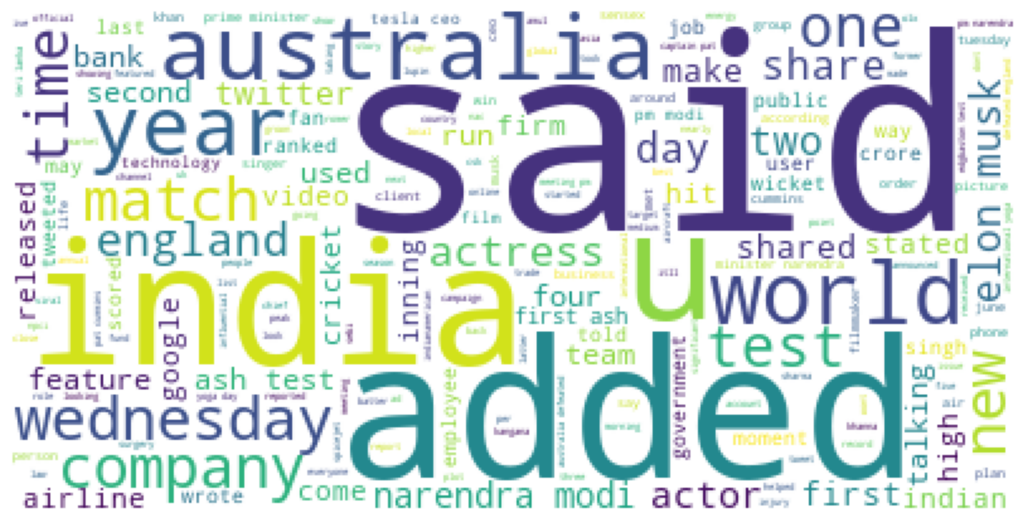

In [153]:
news_cloud = WordCloud(background_color='white').generate(' '.join(all_words))
plt.imshow(news_cloud)
plt.axis('off')
plt.show()

# Notes
* clean function is different than my basic_clean
* clean function has that ADDITIONAL Words list hard_coded
* seems like I should be able to make some of these things into functions
* plotting is more complex than previous/normal. I copied it but I mostly understand what it's doing
* WordCloud(...).generate(thing) needs a single string, so ' '.join(list of words)
* WordCloud.generate_from_frequences needs a dictionary with {'word': count...} see code for to_dict().items() 
    * to_dict makes a series into a dictionary
    * items() makes a dictionary into a list of key, value pairs as tuples. so a list of tuples
* WordCloud makes an image -- show the image with plt.imshow().
*  to turn off grid lines when you show the image: plt.axis('off')

# Forgot to do Sentiment Analysis
* see classroom for the lesson to do that
https://github.com/CodeupClassroom/pagel-nlp/blob/main/exploration_lesson.ipynb